# Feature Selection Techniques

In this workbook, I look at different feature selection methods. This is also called *dimensionality reduction*.

Feature selection is important. Because when number of features increases,
1. Model might impacted due to *curse of dimensionality*. Feature space is so big that model might not be able to effectively learn from the dataset.
2. Model complexity increases. It is hard to interpret the model because it relies on huge number of features. In cases, most of the features may not contribute effectively to the improvement of the metric that we trying to maximize. 
3. Model demands high resources, in terms of time for training and predictions, memory requirements.

In the subsequent text, I will look at different feature selection mechanisms. 


__Important Resources:__
* sklearn user guide: https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection
* Vishal Patel (PyData DC2016)| A Practical Guide to Dimensionality Reduction Techniques: https://www.youtube.com/watch?v=ioXKxulmwVQ
* Krish Naik Video: https://www.youtube.com/watch?v=EqLBAmtKMnQ
* Data School video: https://www.youtube.com/watch?v=YaKMeAlHgqQ

## Data Import and Preliminary Review 

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import dataset
data = pd.read_csv("mobile_handset_data.csv")

# split independant and dependant features 
X = data.iloc[:,:-1]   #independent columns
y = data.iloc[:,-1]    #target column i.e price class

In [2]:
X.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
0,842,0,2.2,0,1,0,7,0.6,188,2,2,20,756,2549,9,7,19,0,0,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,6,905,1988,2631,17,3,7,1,1,0
2,563,1,0.5,1,2,1,41,0.9,145,5,6,1263,1716,2603,11,2,9,1,1,0
3,615,1,2.5,0,0,0,10,0.8,131,6,9,1216,1786,2769,16,8,11,1,0,0
4,1821,1,1.2,0,13,1,44,0.6,141,2,14,1208,1212,1411,8,2,15,1,1,0


In [5]:
X.info()
# As can be seen, there are no null values in the dataset and all are in either int or float format, which suits for the 
# algorithms.
# So, I will not go into EDA or data pre-processing stages in this dataset and directly go into different methods already in
# sklearn for feature selection.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int64  
 18  touch_sc

## Model Evaluation Helper Function

I will just create a helper function to process the 10-fold cross validated result for each transformed dataset. So that we can evaluate the performance of the model with/without the feature selection.

In [79]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_score

def model_performance(X, y, cv = 10):
    classifier = ExtraTreesClassifier()
    mean_score = cross_val_score(classifier, X, y, cv = cv).mean()
    return mean_score

In [81]:
# Extra tree classifier performance with all features
model_performance(X, y)

0.851

## Feature Selection Methods

1. Removing features with low variance
2. Univariate feature selection
3. Recursive Feature Elimination (RFE and RFECV)
4. Feature selection based on SelectFromModel (based on coef_ and feature_importance_ attributes of the model)

### Removing features with low variance

Idea behind this approach is that, if the variance is low or close to zero, then the feature is approximately constant and it will not improve the model performance. 

This is unsupervised way of feature elimination, because it does not look into any dependence of the given feature with respect to the target variable. 

In [87]:
from sklearn.feature_selection import VarianceThreshold

print(f'Number of features in the initial dataset {X.shape[1]}.')

selector = VarianceThreshold(threshold = 0.2)  # Here, we discard features who do not have more than 20% variance. 
X_new = selector.fit_transform(X)

print(f'Number of features after low variance filtering in the dataset {X_new.shape[1]}.')

# get_support() function gives which indices are selected. 
print(f'These features were dropped by the selector: {X.columns[~selector.get_support()]}.')

Number of features in the initial dataset 20.
Number of features after low variance filtering in the dataset 18.
These features were dropped by the selector: Index(['m_dep', 'three_g'], dtype='object').


In [88]:
print(f'Model performance with reduced number of features: {model_performance(X_new, y)}.')

Model performance with reduced number of features: 0.8644999999999999.


### Univariate Selection

Here, we select certain number of features based on their relationship to the output variable. Statistical tests can be used to select the important features those having strong relation with the target variable. 

The scikit-learn library provides the **SelectKBest** class that can be used with a suite of different statistical tests to select a specific number of features.

The example below uses the chi-squared statistical test for non-negative features to select k of the best features from the dataset. 

These objects take as input a scoring function that returns univariate scores and p-values (or only scores for SelectKBest and SelectPercentile):

* For regression: f_regression, mutual_info_regression
* For classification: chi2, f_classif, mutual_info_classif



In [89]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [90]:
# SelectKBest in sklearn to select 10 statistically important features (based on chi-squared test).
selector = SelectKBest(score_func=chi2, k=10)

# fit the dataset to the selector
X_new = selector.fit_transform(X,y)

# statistical test scores for features
scores = selector.scores_

# Let's create a dataframe for the results

df_scores = pd.DataFrame(data={'Feature': X.columns, 'Chi_2 Scores': scores})
df_scores.sort_values(by = 'Chi_2 Scores', ascending = False).reset_index(drop = True)

# As can be seen from below dataframe, there are certain features with very high statistical score. Those high valued
# features are selected by the algorithm.

# X_new contains the extracted dataset. 

,Feature,Chi_2 Scores
0,ram,931267.519053
1,px_height,17363.569536
2,battery_power,14129.866576
3,px_width,9810.586750
4,mobile_wt,95.972863
5,int_memory,89.839124
6,sc_w,16.480319
7,talk_time,13.236400
8,fc,10.135166
9,sc_h,9.614878


In [91]:
print(f'Model performance with reduced number of features: {model_performance(X_new, y)}.')

Model performance with reduced number of features: 0.916.


As can be seen, with the reduced number of features, model complexity reduces significantly and improves the performance as well.

- With full set of features (20 features): 0.851
- With removing low variances (18 features): 0.865
- With univariate selection (10 features): 0.916

### Recursive Feature Elimination

In this method (sklearn: RFE), the external estimator is trained on the initial set of features and the importance of each feature is obtained through attributes such as, __coef___ or __feature_importances___. Then, the least important features are eliminated from the current set of features. 

In [137]:
from sklearn.feature_selection import RFE

classifier = ExtraTreesClassifier()

selector = RFE(estimator=classifier, n_features_to_select=10, step = 1)

X_new = selector.fit_transform(X, y)

feature_rank = selector.ranking_

# Let's create a dataframe for the ranking.

df_ranks = pd.DataFrame(data={'Feature': X.columns, 'Rank': feature_rank})
df_ranks.sort_values(by = 'Rank', ascending = True).reset_index(drop = True)

# As can be seen from below dataframe, there are certain features with rank = 1. Those 10 features are important and also 
# matches with the results that we got from univariate feature selection method (with chi-squared scoring).

# X_new contains the extracted dataset. 

,Feature,Rank
0,battery_power,1
1,talk_time,1
2,sc_w,1
3,sc_h,1
4,ram,1
5,int_memory,1
6,mobile_wt,1
7,px_width,1
8,pc,1
9,px_height,1


In [102]:
print(f'Model performance with reduced number of features: {model_performance(X_new, y)}.')

Model performance with reduced number of features: 0.913.


#### Recursive Feature Elimination with Cross-validation

A recursive feature elimination example with automatic tuning of the number of features selected with cross-validation.

In [182]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

classifier = ExtraTreesClassifier()

selector = RFECV(estimator=classifier, step = 1, cv = StratifiedKFold(5), scoring = 'accuracy')

X_new = selector.fit_transform(X, y)

print(f'Optimal number of features: {selector.n_features_}')

Optimal number of features: 5


In [183]:
print(f'Model performance with RFE_CV feature selection: {model_performance(X_new, y)}.')

Model performance with RFE_CV feature selection: 0.9324999999999999.


In [184]:
# Let's see what features have been selected by the algorithm.
feature_rank = selector.ranking_

# Let's create a dataframe for the ranking.

df_ranks = pd.DataFrame(data={'Feature': X.columns, 'Rank': feature_rank})
df_ranks.sort_values(by = 'Rank', ascending = True).reset_index(drop = True)


,Feature,Rank
0,battery_power,1
1,ram,1
2,px_width,1
3,mobile_wt,1
4,px_height,1
5,int_memory,2
6,talk_time,3
7,sc_w,4
8,pc,5
9,m_dep,6


As can be seen from above, Recursive Feature Elimination with cross validation has tuned features and picked 5 best features for better accuracy score. 

Running the algorithm with this reduced set of features has produced 93.65% accuracy. 

### Feature Selection using SelectFromModel

__SelectFromModel__ is a meta-transformer that can be used with any estimator that has __coef___ or __feature_importance___ attributes after fitting. Feature is eliminated if its respective coef_ or feature_importance_ values are below a certain threshold specified. 

Instead of an absolute threshold, it is also possible to provide string argument for using built-in heuristics for finding a threshold, such as mean, median, etc. It is also possible to specify _max_feature_ argument to limit the number of features to select. 

#### L1-based feature selection

Liner models with penalized with L1-norm of the coefficients for regularization generally provide a sparse solution, where most of the coefficients, which are not important will be zero. 

For the purpose of reducing the dimensionality of the dataset (selecting features), we can use such linear model for coefficient calculation and then use _SelectFromModel_ for selecting the non-zero coefficients. 

Sparse estimators useful for this purpose are the   
- linear_model.Lasso for regression
- linear_model.LogisticRegression and svm.LinearSVC for classification

In [115]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

# With SVMs and logistic-regression, the parameter C controls the sparsity: the smaller C the fewer features selected. 
# With Lasso, the higher the alpha parameter, the fewer features selected.
classifier = LinearSVC(C=0.01, penalty='l1', dual=False).fit(X, y)

selector = SelectFromModel(classifier, prefit=True, max_features=10)

X_new = selector.transform(X)

model_performance(X_new, y)

0.7375

Obviously model performance is not that better with this approach. Below are the features that the model has selected.  

In [123]:
X.columns[selector.get_support(indices=False)]

Index(['clock_speed', 'fc', 'int_memory', 'mobile_wt', 'n_cores', 'pc', 'ram',
       'sc_h', 'sc_w', 'talk_time'],
      dtype='object')

#### Tree-based Feature Selection

Tree-based estimators can be used to compute impurity-based feature importances. This attribute is used in the SelectFromModel meta-transformer to select the features.

In [129]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

classifier = ExtraTreesClassifier()

classifier.fit(X, y)

# Let's see the importance metric for each feature
feature_importances = classifier.feature_importances_

# Let's create a dataframe for the ranking.

df_ranks = pd.DataFrame(data={'Feature': X.columns, 'Importance': feature_importances})
df_ranks.sort_values(by = 'Importance', ascending = False).reset_index(drop = True)

,Feature,Importance
0,ram,0.395361
1,battery_power,0.063954
2,px_width,0.048850
3,px_height,0.047096
4,mobile_wt,0.036430
5,talk_time,0.035162
6,int_memory,0.034126
7,sc_h,0.033661
8,clock_speed,0.033563
9,pc,0.033410


In [135]:
# Let's now feed this to the meta-transformer. 
selector = SelectFromModel(estimator=classifier, threshold='median', max_features=10, prefit = True)

X_new = selector.transform(X)

# Following are the features that the meta-transformer has selected. 
X.columns[selector.get_support()]

Index(['battery_power', 'clock_speed', 'int_memory', 'mobile_wt', 'pc',
       'px_height', 'px_width', 'ram', 'sc_h', 'talk_time'],
      dtype='object')

In [136]:
model_performance(X_new, y)

0.9099999999999999

### Correlation with Target Variable

Correlation shows the degree of relationship between given two variables. It can be either positive or negative, ranges from -1 to +1, where 0 stands for no correlation between the two variables. 

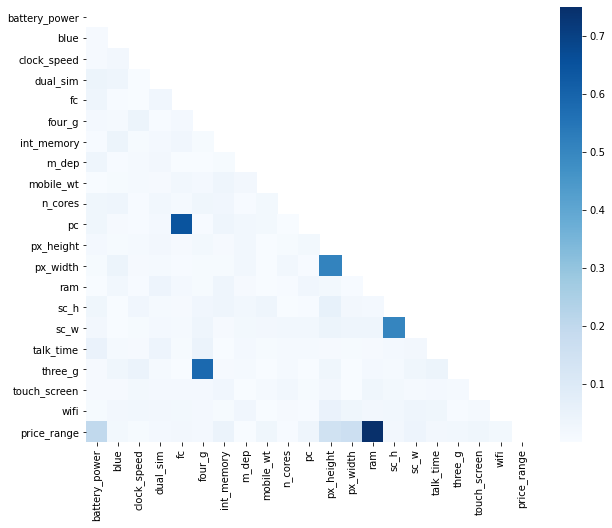

In [168]:
import seaborn as sns

correlation_matrix = data.corr().abs()

# We can plot the correlation on a heat map.

plt.figure(figsize=[10, 8])

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=np.bool))

sns.heatmap(correlation_matrix,cmap="Blues", mask = mask, vmax=0.75)
plt.show()

In [166]:
# Let's calculate the pearson correlation and p-value. 
from scipy.stats import pearsonr

correlation_coeff = []
p_value = []

for column in X.columns:
    coeff, p_val = pearsonr(X[column], y)
    correlation_coeff.append(round(coeff,2))
    p_value.append(round(p_val, 5))

df_correlation = pd.DataFrame(data = {'Features': X.columns,
                                      'Correleation Coeff': correlation_coeff, 
                                      'P-value': p_value                               
                                     })
df_correlation.sort_values(by = 'Correleation Coeff', ascending = False).reset_index(drop = True)

,Features,Correleation Coeff,P-value
0,ram,0.92,0.00000
1,battery_power,0.20,0.00000
2,px_width,0.17,0.00000
3,px_height,0.15,0.00000
4,int_memory,0.04,0.04693
5,sc_w,0.04,0.08349
6,pc,0.03,0.13307
7,blue,0.02,0.35780
8,fc,0.02,0.32546
9,dual_sim,0.02,0.43556


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 <a list of 20 Text major ticklabel objects>)

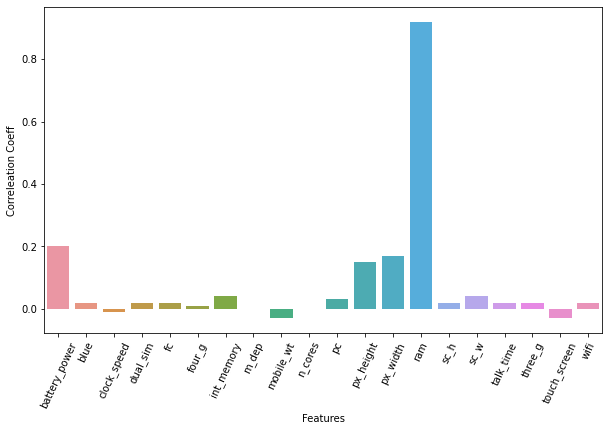

In [180]:
plt.figure(figsize=[10, 6])
sns.barplot(x = df_correlation['Features'], y=df_correlation['Correleation Coeff'])
plt.xticks(rotation = 65)

In [181]:
# As can be seen from the dataframe showing correlation coefficients and P-values, there are only 5 features having 
# p-value < 0.05 and comparatively higher correlation coefficieint. 

# Those are: 'ram', 'battery_power', 'px_width', 'px_height', 'int_memory'
important_features = ['ram', 'battery_power', 'px_width', 'px_height', 'int_memory']

X_new = X[important_features]

model_performance(X_new, y)

0.9275

As shown above, with the limited features model has provided 92.75% accuracy with 5 important features. 

## Feature Selection as a Pipeline

Feature selection is usually used as a pre-processing step before actual learning. So, it is better to keep this as a pipeline.

In [146]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

pipe = Pipeline([('feature_selection', SelectFromModel(estimator = ExtraTreesClassifier(), threshold='median')),
                 ('classification', ExtraTreesClassifier())]
               )

cross_val_score(estimator=pipe, X = X, y = y, cv =5).mean()

0.9109999999999999